In [1]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
INPUT_DIR = '/content/drive/MyDrive/atmaCup/#11/dataset_atmaCup11/'

train = pd.read_csv(INPUT_DIR + 'train.csv')
test = pd.read_csv(INPUT_DIR + 'test.csv')
embeddings = pd.read_csv(INPUT_DIR + 'embeddings.csv')
# materials = pd.read_csv(INPUT_DIR + 'BERT_materials.csv')
techniques = pd.read_csv(INPUT_DIR + 'BERT_techniques.csv')

In [3]:
data = pd.concat([train, test])

In [4]:
data

,object_id,sorting_date,art_series_id,target
0,002bff09b09998d0be65,1631.0,509357f67692a6a45626,1.0
1,00309fb1ef05416f9c1f,1900.0,7987b47bbe5dc3039179,3.0
2,003a1562e97f79ba96dc,1834.0,ded7c3c9636708e5b14c,3.0
3,004890880e8e7431147b,1743.0,582ac2d7f0cef195b605,2.0
4,00718c32602425f504c1,1885.0,64c907f0c08dce4fb8e8,3.0
...,...,...,...,...
5914,ffbe65ad399b632dcbd0,NaN,NaN,NaN
5915,ffd7b2d646c0320c311a,NaN,NaN,NaN
5916,ffdb93ede17d4501e530,NaN,NaN,NaN
5917,ffe111402004b0ed46b4,NaN,NaN,NaN


In [5]:
data = pd.merge(data, embeddings, on='object_id', how='left')
# data = pd.merge(data, materials, on='object_id', how='left')
data = pd.merge(data, techniques, on='object_id', how='left')
data

,object_id,sorting_date,art_series_id,target,Unnamed: 0,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,BERT_techniques_0,BERT_techniques_1
0,002bff09b09998d0be65,1631.0,509357f67692a6a45626,1.0,0,0.085802,-0.109998,0.562253,0.172158,0.235685,0.643984,-0.297035,-0.077914,0.771065,0.296614,0.229186,0.128695,0.799126,-0.735810,-0.858000,0.074083,-0.284740,2.005031
1,00309fb1ef05416f9c1f,1900.0,7987b47bbe5dc3039179,3.0,1,-0.377776,2.203817,-0.209372,-1.753532,-1.332891,-1.804229,-1.207214,0.932346,-1.469298,-1.319072,-0.548625,-1.441100,-2.140274,0.312515,0.133071,0.376945,3.332902,0.422976
2,003a1562e97f79ba96dc,1834.0,ded7c3c9636708e5b14c,3.0,2,-0.314644,-0.918230,-1.005571,0.897702,-0.514858,-1.341578,1.768955,-0.834608,-0.764113,0.370925,-0.045328,0.327708,-0.008963,1.051872,1.209304,-0.412155,-0.638981,0.601329
3,004890880e8e7431147b,1743.0,582ac2d7f0cef195b605,2.0,3,-0.275176,-0.195842,-0.272249,0.571362,-0.034498,-0.306331,1.155633,-0.588240,-0.465584,0.509571,0.049315,0.540030,0.225148,0.733737,0.785568,-0.283782,-2.449574,-1.161011
4,00718c32602425f504c1,1885.0,64c907f0c08dce4fb8e8,3.0,4,-0.267136,-0.408439,-0.572661,0.674455,0.374368,-0.164001,0.796997,-0.680133,0.084354,0.361591,0.450986,0.459829,-0.253252,0.926774,0.382860,-0.806971,-1.513794,-1.077737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9851,ffbe65ad399b632dcbd0,NaN,NaN,NaN,5914,0.770031,-0.234229,0.629901,0.027359,1.060624,1.187675,-0.724965,0.364915,1.133210,0.477653,0.718005,0.196991,-0.067696,-1.222035,-0.838093,0.236990,NaN,NaN
9852,ffd7b2d646c0320c311a,NaN,NaN,NaN,5915,0.070738,-0.355133,0.063620,0.502986,0.131634,0.106500,-0.329814,-0.414935,0.364169,0.587509,0.303484,0.425846,0.117984,0.132747,-0.361223,-0.284736,NaN,NaN
9853,ffdb93ede17d4501e530,NaN,NaN,NaN,5916,0.056158,-0.343251,0.275164,0.291858,0.340172,0.113190,0.414269,-0.350878,0.134322,0.377210,0.177176,0.258334,0.502920,0.207228,0.015563,0.143493,NaN,NaN
9854,ffe111402004b0ed46b4,NaN,NaN,NaN,5917,0.160444,-0.249081,0.607616,0.192381,0.755164,0.857399,-0.397463,-0.133241,0.816307,0.319877,0.293022,0.229697,0.381088,-0.619274,-0.953151,0.206159,NaN,NaN


In [6]:
data.isnull().sum()

object_id               0
sorting_date         5919
art_series_id        5919
target               5919
Unnamed: 0              0
embeddings_0            0
embeddings_1            0
embeddings_2            0
embeddings_3            0
embeddings_4            0
embeddings_5            0
embeddings_6            0
embeddings_7            0
embeddings_8            0
embeddings_9            0
embeddings_10           0
embeddings_11           0
embeddings_12           0
embeddings_13           0
embeddings_14           0
embeddings_15           0
BERT_techniques_0    5920
BERT_techniques_1    5920
dtype: int64

In [9]:
data = data.drop(['sorting_date','target'], axis=1)
train = data[~data['BERT_techniques_0'].isnull()]
test = data[data['BERT_techniques_0'].isnull()]

In [10]:
print(len(train))
print(len(test))

3936
5920


In [12]:
train_x = train.drop(['object_id','art_series_id','Unnamed: 0','BERT_techniques_0', 'BERT_techniques_1'], axis=1)
train_y0 = train.BERT_techniques_0.values
train_y1 = train.BERT_techniques_1.values
groups = np.array(train.art_series_id.values)

BERT_techniques_0の予想

In [13]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [14]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, 
             y, 
             cv, 
             params: dict=None, 
             verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        pred_i[pred_i < 0.0] = 0.0
        pred_i[pred_i > 3.0] = 3.0
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSE: {:.4f}'.format(score))
    return oof_pred, models

In [15]:
params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'objective': 'rmse', 
    
     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    # がそれだけ木を作るため学習に時間がかかります
    'learning_rate': .1,
    
    # L2 Reguralization
    'reg_lambda': 1.,
    # こちらは L1 
    'reg_alpha': .1,
    
    # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'max_depth': 5, 
    
    # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'n_estimators': 10000, 
    
    # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'colsample_bytree': .5, 
    
    # 最小分割でのデータ数. 小さいとより細かい粒度の分割方法を許容します.
    'min_child_samples': 10,
    
    # bagging の頻度と割合
    'subsample_freq': 3,
    'subsample': .9,
    
    # 特徴重要度計算のロジック(後述)
    'importance_type': 'gain', 
    'random_state': 71,
}

In [16]:
from sklearn.model_selection import GroupKFold

In [17]:
group_kfold = GroupKFold(n_splits=5)
group_kfold.get_n_splits(train_x, train_y0, groups)
cv = list(group_kfold.split(train_x, train_y0, groups))

oof, models = fit_lgbm(train_x.values, train_y0, cv, params=params, verbose=500)

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[39]	valid_0's rmse: 1.60768
fit fold=0  0.205[s]
Fold 0 RMSE: 1.6485
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[13]	valid_0's rmse: 1.6332
fit fold=1  0.166[s]
Fold 1 RMSE: 1.6507
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[46]	valid_0's rmse: 1.5871
fit fold=2  0.225[s]
Fold 2 RMSE: 1.6407
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[92]	valid_0's rmse: 1.59442
fit fold=3  0.266[s]
Fold 3 RMSE: 1.6577
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[68]	valid_0's rmse: 1.57288
fit fold=4  0.220[s]
Fold 4 RMSE: 1.6364
--------------------------------------------------
FINISHED | Whole RMSE: 1.6468


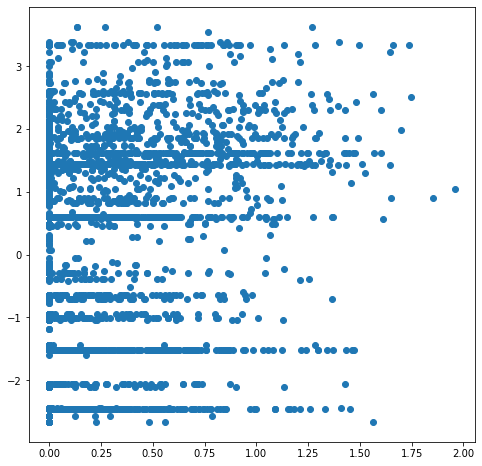

In [18]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(oof, train_y0)

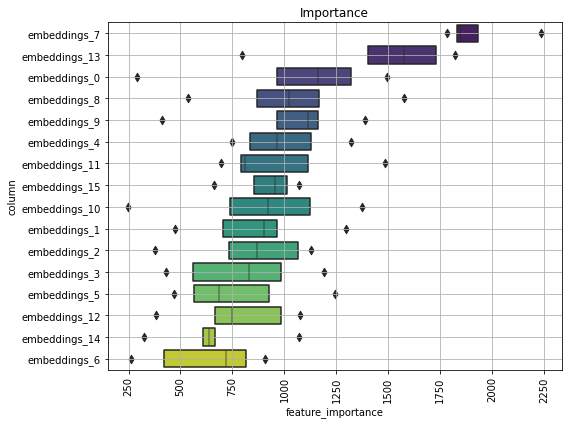

In [19]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.
    
    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(models, train_x)

In [20]:
test.columns

Index(['object_id', 'art_series_id', 'Unnamed: 0', 'embeddings_0',
       'embeddings_1', 'embeddings_2', 'embeddings_3', 'embeddings_4',
       'embeddings_5', 'embeddings_6', 'embeddings_7', 'embeddings_8',
       'embeddings_9', 'embeddings_10', 'embeddings_11', 'embeddings_12',
       'embeddings_13', 'embeddings_14', 'embeddings_15', 'BERT_techniques_0',
       'BERT_techniques_1'],
      dtype='object')

In [21]:
BERT_techniques_0 = np.array([model.predict(test.drop(['object_id','art_series_id','Unnamed: 0','BERT_techniques_0', 'BERT_techniques_1'],axis=1).values) for model in models])
BERT_techniques_0 = np.mean(BERT_techniques_0, axis=0)

In [22]:
BERT_techniques_0.shape

(5920,)

In [23]:
test['BERT_techniques_0'] = BERT_techniques_0
test.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,object_id,art_series_id,Unnamed: 0,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,BERT_techniques_0,BERT_techniques_1
1468,60c1cacb453d497ad3a4,7082ba275d243b0ab7d2,1468,-0.094184,-0.478360,-0.353080,0.691911,-0.036240,-0.142248,0.947475,-0.578863,-0.124026,0.426786,0.288977,0.414208,0.079633,0.676045,0.042411,-0.458110,-0.411164,NaN
3937,0009e50b94be36ccad39,NaN,0,0.570215,1.063630,0.052811,-1.560300,-0.675400,-1.247149,-1.749140,0.990440,-0.872756,-1.318930,-1.015395,-1.591988,-3.639592,0.816642,0.214954,1.394029,-0.759844,NaN
3938,000bd5e82eb22f199f44,NaN,1,-1.605843,3.036374,-1.368456,-2.591912,-2.780293,-2.262587,-2.813619,2.018298,-3.526314,-2.262575,-1.603812,-2.540917,-4.483867,-0.196065,1.602043,0.694979,0.362970,NaN
3939,0015f44de1854f617516,NaN,2,-0.121114,-0.386386,0.056263,0.448212,0.305930,0.071638,0.050771,-0.299689,0.098024,0.382984,0.231504,0.346462,0.649204,0.360708,-0.215444,-0.239241,0.300570,NaN
3940,00388a678879ba1efa27,NaN,3,-0.068046,-0.236767,-0.239425,0.660831,-0.091604,-0.726467,0.833901,-0.548133,-0.462072,0.674938,0.048107,0.498703,0.535219,1.118490,1.027464,-0.355963,-0.951133,NaN


BERT_techniques_1の予想

In [24]:
group_kfold = GroupKFold(n_splits=5)
group_kfold.get_n_splits(train_x, train_y1, groups)
cv = list(group_kfold.split(train_x, train_y1, groups))

oof, models = fit_lgbm(train_x.values, train_y1, cv, params=params, verbose=500)

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[14]	valid_0's rmse: 1.11368
fit fold=0  0.156[s]
Fold 0 RMSE: 1.1368
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[15]	valid_0's rmse: 1.15663
fit fold=1  0.206[s]
Fold 1 RMSE: 1.1689
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[28]	valid_0's rmse: 1.13802
fit fold=2  0.168[s]
Fold 2 RMSE: 1.1653
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[19]	valid_0's rmse: 1.2001
fit fold=3  0.181[s]
Fold 3 RMSE: 1.2146
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[31]	valid_0's rmse: 1.15711
fit fold=4  0.174[s]
Fold 4 RMSE: 1.1778
--------------------------------------------------
FINISHED | Whole RMSE: 1.1729


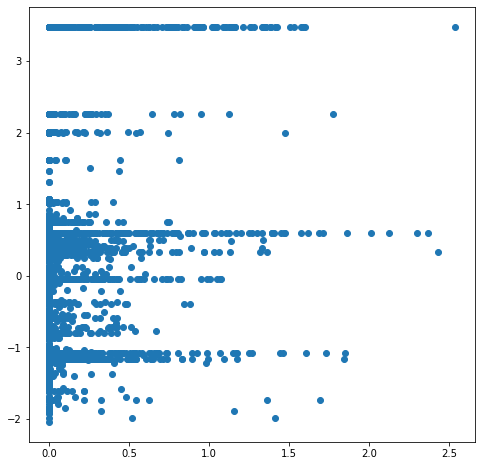

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(oof, train_y1)

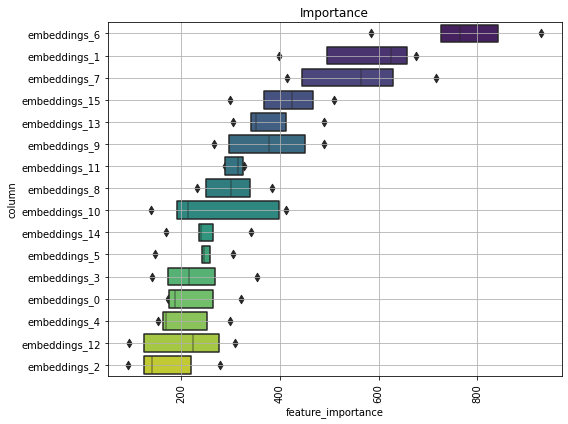

In [26]:
fig, ax = visualize_importance(models, train_x)

In [27]:
BERT_techniques_1 = np.array([model.predict(test.drop(['object_id','art_series_id','Unnamed: 0','BERT_techniques_0', 'BERT_techniques_1'],axis=1).values) for model in models])
BERT_techniques_1 = np.mean(BERT_techniques_1, axis=0)

In [28]:
test['BERT_techniques_1'] = BERT_techniques_1
test.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,object_id,art_series_id,Unnamed: 0,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,BERT_techniques_0,BERT_techniques_1
1468,60c1cacb453d497ad3a4,7082ba275d243b0ab7d2,1468,-0.094184,-0.478360,-0.353080,0.691911,-0.036240,-0.142248,0.947475,-0.578863,-0.124026,0.426786,0.288977,0.414208,0.079633,0.676045,0.042411,-0.458110,-0.411164,0.255229
3937,0009e50b94be36ccad39,NaN,0,0.570215,1.063630,0.052811,-1.560300,-0.675400,-1.247149,-1.749140,0.990440,-0.872756,-1.318930,-1.015395,-1.591988,-3.639592,0.816642,0.214954,1.394029,-0.759844,-0.418247
3938,000bd5e82eb22f199f44,NaN,1,-1.605843,3.036374,-1.368456,-2.591912,-2.780293,-2.262587,-2.813619,2.018298,-3.526314,-2.262575,-1.603812,-2.540917,-4.483867,-0.196065,1.602043,0.694979,0.362970,-0.341082
3939,0015f44de1854f617516,NaN,2,-0.121114,-0.386386,0.056263,0.448212,0.305930,0.071638,0.050771,-0.299689,0.098024,0.382984,0.231504,0.346462,0.649204,0.360708,-0.215444,-0.239241,0.300570,0.013926
3940,00388a678879ba1efa27,NaN,3,-0.068046,-0.236767,-0.239425,0.660831,-0.091604,-0.726467,0.833901,-0.548133,-0.462072,0.674938,0.048107,0.498703,0.535219,1.118490,1.027464,-0.355963,-0.951133,0.058541


In [29]:
data = pd.concat([train,test])

In [30]:
data.head()

,object_id,art_series_id,Unnamed: 0,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,BERT_techniques_0,BERT_techniques_1
0,002bff09b09998d0be65,509357f67692a6a45626,0,0.085802,-0.109998,0.562253,0.172158,0.235685,0.643984,-0.297035,-0.077914,0.771065,0.296614,0.229186,0.128695,0.799126,-0.735810,-0.858000,0.074083,-0.284740,2.005031
1,00309fb1ef05416f9c1f,7987b47bbe5dc3039179,1,-0.377776,2.203817,-0.209372,-1.753532,-1.332891,-1.804229,-1.207214,0.932346,-1.469298,-1.319072,-0.548625,-1.441100,-2.140274,0.312515,0.133071,0.376945,3.332902,0.422976
2,003a1562e97f79ba96dc,ded7c3c9636708e5b14c,2,-0.314644,-0.918230,-1.005571,0.897702,-0.514858,-1.341578,1.768955,-0.834608,-0.764113,0.370925,-0.045328,0.327708,-0.008963,1.051872,1.209304,-0.412155,-0.638981,0.601329
3,004890880e8e7431147b,582ac2d7f0cef195b605,3,-0.275176,-0.195842,-0.272249,0.571362,-0.034498,-0.306331,1.155633,-0.588240,-0.465584,0.509571,0.049315,0.540030,0.225148,0.733737,0.785568,-0.283782,-2.449574,-1.161011
4,00718c32602425f504c1,64c907f0c08dce4fb8e8,4,-0.267136,-0.408439,-0.572661,0.674455,0.374368,-0.164001,0.796997,-0.680133,0.084354,0.361591,0.450986,0.459829,-0.253252,0.926774,0.382860,-0.806971,-1.513794,-1.077737


In [31]:
data.isnull().sum()

object_id               0
art_series_id        5919
Unnamed: 0              0
embeddings_0            0
embeddings_1            0
embeddings_2            0
embeddings_3            0
embeddings_4            0
embeddings_5            0
embeddings_6            0
embeddings_7            0
embeddings_8            0
embeddings_9            0
embeddings_10           0
embeddings_11           0
embeddings_12           0
embeddings_13           0
embeddings_14           0
embeddings_15           0
BERT_techniques_0       0
BERT_techniques_1       0
dtype: int64

In [32]:
data = data[['object_id','BERT_techniques_0','BERT_techniques_1']]

In [33]:
data.to_csv(os.path.join(INPUT_DIR, 'BERT_techniques_all.csv'), index=False)